In [1]:
from pathlib import Path
import polars as pl

from e2e_taxi_ride_duration_prediction.ingestion import get_nyc_taxi_data

if Path().resolve().name == "notebooks":
    PROJECT_ROOT = Path("../").resolve()
else:
    PROJECT_ROOT = Path().resolve()

In [2]:
start = (2019, 11)
end = (2020, 3)
lf = get_nyc_taxi_data(root=PROJECT_ROOT, start=start, end=end)

In [3]:
lf.describe()

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.948649e7,"""29486490""","""29486490""",2.9235898e7,2.948649e7,2.9235898e7,"""29235898""",2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.948649e7,2.9235896e7,0.0
"""null_count""",0.0,"""0""","""0""",250592.0,0.0,250592.0,"""250592""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250594.0,2.948649e7
"""mean""",1.669492,"""2020-01-06 11:47:11.605617""","""2020-01-06 12:04:19.053268""",1.522659,2.944897,1.059622,null,164.152709,162.045534,1.266029,13.042819,1.124695,0.509532,2.218243,0.355108,0.297975,19.068458,2.296846,null
"""std""",0.470825,null,null,1.158539,79.338525,0.824985,null,65.83455,70.090756,0.489884,144.246253,92.087078,92.078579,2.780891,1.729232,0.033955,234.075919,0.705191,null
"""min""",1.0,"""2003-01-01 00:00:00""","""2003-01-01 00:01:44""",0.0,-37264.53,1.0,"""N""",1.0,1.0,0.0,-1472.0,-27.0,-0.5,-493.22,-40.5,-0.3,-1472.8,-2.5,null
"""25%""",1.0,"""2019-12-03 13:45:44""","""2019-12-03 14:04:34""",1.0,0.96,1.0,null,125.0,113.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5,null
"""50%""",2.0,"""2020-01-06 16:18:13""","""2020-01-06 16:34:40""",1.0,1.6,1.0,null,162.0,162.0,1.0,9.5,0.5,0.5,1.95,0.0,0.3,14.75,2.5,null
"""75%""",2.0,"""2020-02-09 22:12:59""","""2020-02-09 22:29:53""",2.0,2.98,1.0,null,233.0,234.0,2.0,14.5,2.5,0.5,2.95,0.0,0.3,20.47,2.5,null
"""max""",6.0,"""2090-12-31 06:41:26""","""2090-12-31 07:18:49""",9.0,269803.73,99.0,"""Y""",265.0,265.0,5.0,671100.14,500000.8,500000.5,1100.0,925.5,0.3,1000003.8,3.0,null


## Cleaning

In [4]:
# some earlier versions of the dataset named the airport fee column as "Airport_fee" instead of "airport_fee"
if "Airport_fee" in lf.collect_schema().names():
    lf = lf.with_columns(
        pl.coalesce(pl.col("Airport_fee"), pl.col("airport_fee")).alias("airport_fee")
    ).drop("airport_fee")

# drop airport_fee if it is not present in the dataset
if lf.select("airport_fee").count().collect()[0, 0] == 0:
    lf = lf.drop("airport_fee")

In [5]:
# Filter time range
filter_end_month = 1 if end[1] == 12 else end[1] + 1
filter_end_year = end[0]+1 if filter_end_month == 1 else end[0] 
print(f"Filtering data from {start[0]}-{start[1]} to {filter_end_year}-{filter_end_month}")
lf = lf.filter(
    (pl.col("tpep_pickup_datetime") <= pl.datetime(filter_end_year, filter_end_month, 1)) &
    (pl.col("tpep_pickup_datetime") >= pl.datetime(start[0], start[1], 1)) 
).sort("tpep_pickup_datetime")

Filtering data from 2019-11 to 2020-4


In [6]:
lf.collect_schema()

Schema([('VendorID', Int64),
        ('tpep_pickup_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('tpep_dropoff_datetime', Datetime(time_unit='ns', time_zone=None)),
        ('passenger_count', Float64),
        ('trip_distance', Float64),
        ('RatecodeID', Float64),
        ('store_and_fwd_flag', String),
        ('PULocationID', Int64),
        ('DOLocationID', Int64),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('congestion_surcharge', Float64)])

In [7]:
# remove duplicates
lf = lf.unique(maintain_order=True)

In [ ]:
lf.describe()

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.9472883e7,"""29472883""","""29472883""",2.923524e7,2.9472883e7,2.923524e7,"""29235240""",2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9472883e7,2.9235238e7
"""null_count""",0.0,"""0""","""0""",237643.0,0.0,237643.0,"""237643""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237645.0
"""mean""",1.66934,"""2020-01-06 12:13:39.267998""","""2020-01-06 12:30:46.256007""",1.522652,2.943076,1.059621,null,164.165693,162.059422,1.266583,13.034468,1.123968,0.509604,2.219196,0.354527,0.297974,19.060472,2.296849
"""std""",0.47088,null,null,1.158532,79.356649,0.82499,null,65.82811,70.085403,0.489272,144.278729,92.108324,92.099831,2.781061,1.728305,0.033961,234.129429,0.705187
"""min""",1.0,"""2019-11-01 00:00:00""","""2019-11-01 00:00:43""",0.0,-37264.53,1.0,"""N""",1.0,1.0,0.0,-1472.0,-27.0,-0.5,-493.22,-40.5,-0.3,-1472.8,-2.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""25%""",1.0,"""2019-12-03 13:32:02""","""2019-12-03 13:51:09""",1.0,0.96,1.0,null,125.0,113.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5
"""50%""",2.0,"""2020-01-06 15:50:59""","""2020-01-06 16:06:26""",1.0,1.6,1.0,null,162.0,162.0,1.0,9.5,0.5,0.5,1.95,0.0,0.3,14.75,2.5
"""75%""",2.0,"""2020-02-09 22:49:37""","""2020-02-09 23:07:07""",2.0,2.98,1.0,null,234.0,234.0,2.0,14.5,2.5,0.5,2.95,0.0,0.3,20.47,2.5


In [9]:
# Check if null values are 
lf.drop_nulls().describe()

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.9235238e7,"""29235238""","""29235238""",2.9235238e7,2.9235238e7,2.9235238e7,"""29235238""",2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7,2.9235238e7
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.666576,"""2020-01-06 11:03:33.934359""","""2020-01-06 11:20:34.832204""",1.522652,2.869692,1.059621,null,164.391466,162.316501,1.276878,12.887945,1.113727,0.510885,2.236444,0.343549,0.29796,18.923023,2.296849
"""std""",0.471437,null,null,1.158532,5.166034,0.82499,null,65.707195,69.986414,0.477689,144.849468,92.481787,92.473397,2.78428,1.710692,0.034086,235.070041,0.705187
"""min""",1.0,"""2019-11-01 00:00:00""","""2019-11-01 00:00:43""",0.0,-23.01,1.0,"""N""",1.0,1.0,1.0,-1472.0,-27.0,-0.5,-493.22,-40.5,-0.3,-1472.8,-2.5
"""25%""",1.0,"""2019-12-03 12:49:47""","""2019-12-03 13:08:05""",1.0,0.96,1.0,null,125.0,113.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5
"""50%""",2.0,"""2020-01-06 14:46:26""","""2020-01-06 15:00:40""",1.0,1.6,1.0,null,162.0,162.0,1.0,9.5,0.5,0.5,1.96,0.0,0.3,14.75,2.5
"""75%""",2.0,"""2020-02-09 20:48:15""","""2020-02-09 21:04:08""",2.0,2.92,1.0,null,234.0,234.0,2.0,14.5,2.5,0.5,2.96,0.0,0.3,20.3,2.5
"""max""",2.0,"""2020-03-31 23:59:28""","""2020-04-01 18:03:32""",9.0,19130.18,99.0,"""Y""",265.0,265.0,5.0,671100.14,500000.8,500000.5,1100.0,925.5,0.3,1000003.8,3.0



# Data Overview
The data is for the Yellow Taxis in New York (most common taxis, can pickup passengers anywhere in new york via street hails in contrast to green taxis). For now the green taxis are excluded, but may be included in future iterations. 

## Data Fields
|Field Name|Description|
|:---|:---|
|`VendorID`| A code indicating the TPEP provider that provided the record.<br>1 = Creative Movile Technologies, LLC<br>2 = Curb Mobility, LLC<br>6 = Myle Technologies Inc<br>7 = Helix|
|`tpep_pickup_datetime`|The date and time when the meter was engaged.|
|`tpep_dropoff_dateteime`|The date and time when the meter was disengaged.|
|`passenger_count`|The number of passengers in the vehicle|
|`trip_distance`|The elapsed trip distance in miles reported by the taximeter.|
|`RatecodeID`|The final rate code in effect at the end of the trip.<br>1 = Standard rate<br>2 = JFK<br>3 = Newark<br>4 = Nassau or Westchester<br>5 = Negotiated fare<br>6 = Group ride<br>99 = Null/unknown|
|`store_and_fwd_flag`|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br> aka “store and forward,” because the vehicle did not have a connection to the server.<br>Y = store and forward trip<br>N = not a store and forward trip|
|`PULocationID`|PULocationID TLC Taxi Zone in which the taximeter was engaged.|
|`DOLocationID`|PULocationID TLC Taxi Zone in which the taximeter was disengaged.|
|`payment_type`|A numeric code signifying how the passenger paid for the trip.<br>0 = Flex Fare trip<br>1 = Credit card<br>2 = Cash<br>3 = No charge<br>4 = Dispute<br>5 = Unknown<br>6 = Voided trip|
|`fare_amount`|The time-and-distance fare calculated by the meter.<br>For additional information on the following columns, see [https://www.nyc.gov/site/tlc/passengers/taxi-fare.page](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)|
|`extra`|Miscellaneous extras and surcharges.|
|`mta_tax`|Tax that is automatically trigerred based on the metered rate in use.|
|`tip_amount`|Tip amount = This field is automatically populated for credit card tips. Cash tips are not included|
|`tolls_amount`|Total amount of all tolls paid in trip.|
|`improvement_surcharge`|Improvement surcharge assessed trips at the flag drop.<br>The improvement
surcharge began being levied in 2015.|
|`total_amount`|The total amount charged to passengers. Does not include cash tips.|
|`congestion_surcharge`|Total amount collected in trip for NYS congestion surcharge.|
|`airport_fee`|For pick up only at LaGuardia and John F. Kennedy Airports.|
|`cbd_congestion_fee`|Per-trip charge for MTA's Congestion Relief Zone starting Jan. 5, 2025|

> Source: [https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

In [10]:
# Create target from pickup and dropoff datetimes
lf = lf.with_columns(((pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_seconds() / 60).alias("duration"))

In [11]:
# Split into train/test/ future sets
train_end = pl.datetime(2020, 2, 1)
test_end = pl.datetime(2020, 3, 1)
lf_train = lf.filter(pl.col("tpep_pickup_datetime") < train_end)
lf_test = lf.filter((pl.col("tpep_pickup_datetime") >= train_end) & (pl.col("tpep_pickup_datetime") < test_end))
lf_future = lf.filter(pl.col("tpep_pickup_datetime") >= test_end)

In [13]:
lf_train.describe(
    percentiles=[0.01, 0.25, 0.5, 0.75, 0.99], 
)

statistic,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.0166098e7,"""20166098""","""20166098""",2.0015097e7,2.0166098e7,2.0015097e7,"""20015097""",2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0166098e7,2.0015095e7,2.0166098e7
"""null_count""",0.0,"""0""","""0""",151001.0,0.0,151001.0,"""151001""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151003.0,0.0
"""mean""",1.667613,"""2019-12-15 14:38:31.709142""","""2019-12-15 14:56:10.912187""",1.536533,2.941661,1.062016,null,164.139158,162.078996,1.274478,13.218092,1.110417,0.492727,2.230734,0.370506,0.298049,19.239621,2.297818,17.653384
"""std""",0.471081,null,null,1.168078,48.075587,0.854747,null,65.803027,70.08223,0.491414,89.591218,1.259524,0.071272,2.825075,1.761448,0.033287,90.007285,0.70287,68.092639
"""min""",1.0,"""2019-11-01 00:00:00""","""2019-11-01 00:00:43""",0.0,-37264.53,1.0,"""N""",1.0,1.0,0.0,-1472.0,-27.0,-0.5,-200.8,-40.5,-0.3,-1472.8,-2.5,-5779.466667
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""25%""",1.0,"""2019-11-21 23:28:57""","""2019-11-21 23:45:33""",1.0,0.96,1.0,null,125.0,113.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5,6.7
"""50%""",2.0,"""2019-12-13 22:41:21""","""2019-12-13 23:00:53""",1.0,1.6,1.0,null,162.0,162.0,1.0,9.5,0.5,0.5,1.95,0.0,0.3,14.76,2.5,11.266667
"""75%""",2.0,"""2020-01-08 15:41:07""","""2020-01-08 15:57:23""",2.0,3.0,1.0,null,233.0,234.0,2.0,14.5,2.5,0.5,2.96,0.0,0.3,20.76,2.5,18.483333


In [20]:
import polars.selectors as cs
import seaborn as sns
sns.set_theme()

correlation = lf_train.select(cs.exclude("store_and_fwd_flag")).collect().corr()

In [21]:
correlation

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.009425,0.009487,NaN,0.002604,NaN,-0.010789,-0.005858,-0.02682,0.002637,-0.8516,-0.034855,0.017952,0.011309,-0.038692,0.00336,NaN,0.035103
0.009425,1.0,0.999998,NaN,-0.000253,NaN,0.004769,0.003025,-0.004282,-0.003736,0.001446,-0.002998,-0.014236,-0.009405,-0.002813,-0.00425,NaN,-0.015609
0.009487,0.999998,1.0,NaN,-0.000233,NaN,0.004741,0.002992,-0.00429,-0.0037,0.001407,-0.003005,-0.014112,-0.009269,-0.002806,-0.004208,NaN,-0.013845
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002604,-0.000253,-0.000233,NaN,1.0,NaN,-0.008133,-0.008228,-0.003536,0.009391,9.9246e-7,-0.006326,0.040485,0.046155,0.001366,0.011441,NaN,0.0115
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.011309,-0.009405,-0.009269,NaN,0.046155,NaN,-0.047181,-0.059884,-0.04473,0.075947,0.002443,-0.151425,0.398178,1.0,0.016427,0.107096,NaN,0.077435
-0.038692,-0.002813,-0.002806,NaN,0.001366,NaN,0.002089,-0.000012,-0.21917,0.012594,0.065054,0.749696,0.04138,0.016427,1.0,0.018147,NaN,0.004005
0.00336,-0.00425,-0.004208,NaN,0.011441,NaN,-0.012299,-0.013137,-0.025855,0.99903,0.00326,-0.015598,0.11291,0.107096,0.018147,1.0,NaN,0.023733


In [24]:
cleaned_correlation = lf_train.select(cs.exclude(["store_and_fwd_flag", "passenger_count", "RatecodeID", "congestion_surcharge"])).collect().corr()

In [25]:
cleaned_correlation

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.009425,0.009487,0.002604,-0.010789,-0.005858,-0.02682,0.002637,-0.8516,-0.034855,0.017952,0.011309,-0.038692,0.00336,0.035103
0.009425,1.0,0.999998,-0.000253,0.004769,0.003025,-0.004282,-0.003736,0.001446,-0.002998,-0.014236,-0.009405,-0.002813,-0.00425,-0.015609
0.009487,0.999998,1.0,-0.000233,0.004741,0.002992,-0.00429,-0.0037,0.001407,-0.003005,-0.014112,-0.009269,-0.002806,-0.004208,-0.013845
0.002604,-0.000253,-0.000233,1.0,-0.008133,-0.008228,-0.003536,0.009391,9.9246e-7,-0.006326,0.040485,0.046155,0.001366,0.011441,0.0115
-0.010789,0.004769,0.004741,-0.008133,1.0,0.101747,-0.020157,-0.011335,0.017703,0.009712,-0.029346,-0.047181,0.002089,-0.012299,-0.015629
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.017952,-0.014236,-0.014112,0.040485,-0.029346,-0.032554,-0.441327,0.073841,0.001547,-0.05424,1.0,0.398178,0.04138,0.11291,0.070573
0.011309,-0.009405,-0.009269,0.046155,-0.047181,-0.059884,-0.04473,0.075947,0.002443,-0.151425,0.398178,1.0,0.016427,0.107096,0.077435
-0.038692,-0.002813,-0.002806,0.001366,0.002089,-0.000012,-0.21917,0.012594,0.065054,0.749696,0.04138,0.016427,1.0,0.018147,0.004005


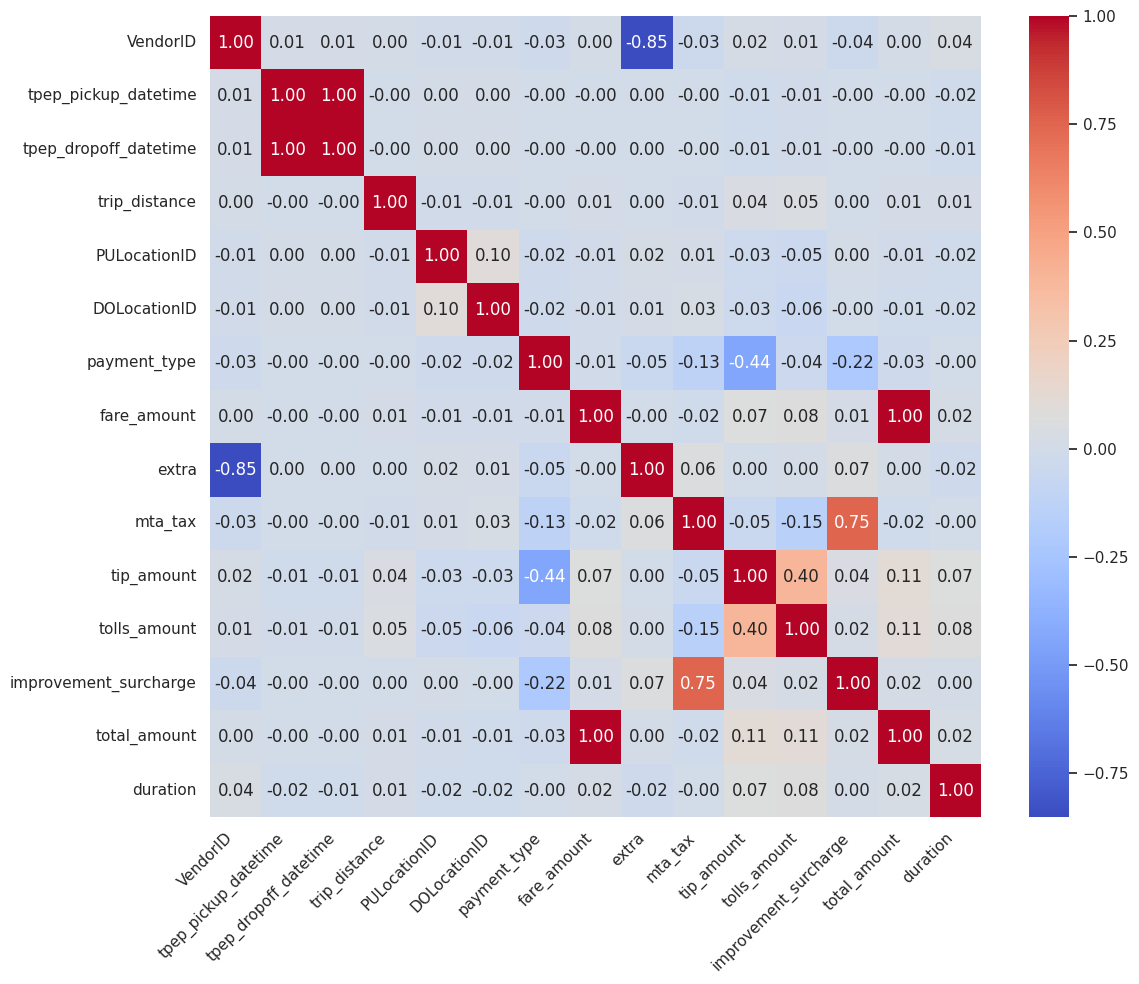

In [44]:
import matplotlib.pyplot as plt

heatmap = sns.heatmap(cleaned_correlation, cmap="coolwarm", 
                      xticklabels=cleaned_correlation.columns,
                      yticklabels=cleaned_correlation.columns,
                      annot=True, fmt=".2f",)
heatmap.figure.set_size_inches(12, 10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()